In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 10 10:59:39 2019

@author: Katherine, Ki Wan
"""

import csv
import os
from functools import partial
import json
import numpy as np
import geopandas as gpd
import matplotlib

import matplotlib.pyplot as plt
#import seaborn as sns
import networkx as nx
import random


from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)
from gerrychain.metrics import efficiency_gap, mean_median, partisan_gini
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part
from gerrychain.accept import always_accept



In [2]:
num_districts = 14
output_dirname = "Run_1"

newdir = "./Outputs/"
os.makedirs(os.path.dirname(newdir + "init.txt"), exist_ok=True)
with open(newdir + "init.txt", "w") as f:
    f.write("Created Folder")
    
graph = Graph.from_json("./data/ga_2012_BG.json")
df = gpd.read_file("./data/ga_2012_BG.gpkg")


In [3]:
df.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'GEOID', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'CIT_EST AIAN_Alone', 'CIT_EST HISP', 'CIT_EST NH', 'CIT_EST NH_ASIAN',
       'CIT_EST NH_BLACK', 'CIT_EST NH_NHPI', 'CIT_EST NH_WHITE',
       'CIT_EST TOT', 'CVAP_EST AIAN_Alone', 'CVAP_EST HISP', 'CVAP_EST NH',
       'CVAP_EST NH_ASIAN', 'CVAP_EST NH_BLACK', 'CVAP_EST NH_NHPI',
       'CVAP_EST NH_WHITE', 'CVAP_EST TOT', 'geometry'],
      dtype='object')

In [4]:
# SUMMING DATA WE WANT IN THE DATAFRAME
import pandas as pd 

new_cols = ['CPOP', 'CVAP', 'BCVAP', 'BCPOP', 'HCVAP', 'HCPOP', 'minCPOP']


CPOP_cols = ['CIT_EST TOT', ]
CVAP_cols = ['CVAP_EST TOT', ]
BCVAP_cols = ['CVAP_EST NH_BLACK', ]
BCPOP_cols = ['CIT_EST NH_BLACK', ]
HCVAP_cols = ['CVAP_EST HISP', ]
HCPOP_cols = ['CIT_EST HISP', ]


df['CPOP'] = pd.to_numeric(df['CIT_EST TOT'])
df['CVAP'] = pd.to_numeric(df['CVAP_EST TOT'])
df['BCVAP'] = pd.to_numeric(df['CVAP_EST NH_BLACK'])
df['BCPOP'] = pd.to_numeric(df['CIT_EST NH_BLACK'])
df['HCVAP'] = pd.to_numeric(df['CVAP_EST HISP'])
df['HCPOP'] = pd.to_numeric(df['CIT_EST HISP'])

df['nBCVAP'] = df['CVAP'] - df['BCVAP']
df['nBCPOP'] = df['CPOP'] - df['BCPOP']
df['minCPOP'] = df['BCPOP'] + df['HCPOP']
df['minCVAP'] = df['BCVAP'] + df['HCVAP'] 
df['nminCPOP'] = df['CPOP'] - df['minCPOP']
df['nminCVAP'] = df['CVAP'] - df['minCVAP']

In [5]:
# ADD NEW DATA TO GRAPH 

graph.add_data(df, columns=new_cols)

In [6]:
# INITIAL PARTITION ASSIGNMENT USING RECURSIVE TREE PARTITION
TOTPOP = 9714569

starts = []

for i in range(1):
    starts.append(recursive_tree_part(graph,range(num_districts),df['CPOP'].sum()/num_districts, "CPOP", .001, 1))

In [10]:
updater = {
    "population": updaters.Tally("CPOP", alias="population"),
    "cut_edges": cut_edges,
    "BCVAP":Election("BCVAP",{"BCVAP":"BCVAP","nBCVAP":"nBCVAP"}),
    "BCPOP":Election("BCPOP",{"BCPOP":"BCPOP","nBCPOP":"nBCPOP"}),   
    "minCVAP":Election("minCVAP",{"minCVAP":"minCVAP","nminCVAP":"nminCVAP"}),
    "minCPOP":Election("minCPOP",{"minCPOP":"minCPOP","nminCPOP":"nminCPOP"})
}

initial_partitions = []
proposals = []
compactness_bounds = []
chains=[]

for i in range(1):
    initial_partitions.append(Partition(graph,starts[i], updater))
    print("initial partition is made")

    proposals.append(partial(
        recom, pop_col="CPOP", pop_target=df['CPOP'].sum()/num_districts, epsilon=.01, node_repeats=1 # e = .02
    ))

    compactness_bounds.append(constraints.UpperBound(
        lambda p: len(p["cut_edges"]), 2 * len(initial_partitions[i]["cut_edges"])
    ))

    chains.append(MarkovChain(
        proposal=proposals[i],
        constraints=[
            constraints.within_percent_of_ideal_population(initial_partitions[i], .01), compactness_bounds[i] # e = .05
          #constraints.single_flip_contiguous#no_more_discontiguous 
        #constraints.within_percent_of_ideal_population(initial_partitions[i], .3)
        ],
        accept=always_accept,
        initial_state=initial_partitions[i],
        total_steps=10000
    ))


initial partition is made


In [109]:
cuts=[[],[],[],[]]
#BVAPS=[[],[],[],[]]
BCVAPS=[[],[],[],[]]
#BHVAPS=[[],[],[],[]]
BHCVAPS=[[],[],[],[]]
BMM_dist=[[],[]]
BCMM_dist=[[],[]]
BHMM_dist=[[],[]]
BHCMM_dist=[[],[]]

# GA Senate as of 2019: 21 Dem, 35 Rep
currentD = 21

subdir = "./Outputs/Tract_Senate_TOTPOP/"
os.makedirs(os.path.dirname(subdir + "init.txt"), exist_ok=True)
with open(subdir + "init.txt", "w") as f:
    f.write("Created Folder")

outputdir_BVAP = './Outputs/BG_14Districts_CPOP/BVAP_Better_Than_Current/'
outputdir_minVAP =  './Outputs/BG_14Districts_CPOP/minVAP_Better_Than_Current/'

for i in range(1):
    t = 0
    for part in chains[i]:
        cuts[i].append(len(part["cut_edges"]))
        BVAPS[i].append(sorted(part["BVAP"].percents("BVAP")))
        BCVAPS[i].append(sorted(part["BCVAP"].percents("BCVAP")))
        BHVAPS[i].append(sorted(part["BHVAP"].percents("BHVAP")))
        BHCVAPS[i].append(sorted(part["BHCVAP"].percents("BHCVAP")))

        num_BMM_dist = part["BVAP"].seats("BVAP")
        BMM_dist[i].append(num_BMM_dist)
        
        num_BCMM_dist = part["BCVAP"].seats("BCVAP")
        BCMM_dist[i].append(num_BCMM_dist)
        
        num_BHMM_dist = part["BHVAP"].seats("BHVAP")
        BHMM_dist[i].append(num_BHMM_dist)
        
        num_BHCMM_dist = part["BHCVAP"].seats("BHCVAP")
        BHCMM_dist[i].append(num_BHCMM_dist)
        t+=1
    
        if (num_BMM_dist > currentD):
            print("chain",i,"step",t, "num_BMM_dist >", currentD)
            
            df.plot(column="current",cmap="jet")
            plt.savefig(outputdir_BVAP+"plot_BMM_"+str(t)+".png")
            plt.close()

            with open(outputdir_BVAP+"assignment_BMM_"+str(t)+".json", 'w') as jf1:
                json.dump(dict(part.assignment), jf1)
        
        if (num_BHMM_dist > currentD):
            print("chain",i,"step",t, "num_BHMM_dist >", currentD)
            
            df.plot(column="current",cmap="jet")
            plt.savefig(outputdir_minVAP+"plot_BHMM_"+str(t)+".png")
            plt.close()

            with open(outputdir_minVAP+"assignment_BHMM_"+str(t)+".json", 'w') as jf1:
                json.dump(dict(part.assignment), jf1)
    
        if t%100 ==0:
            print("chain",i,"step",t)
            
    print(f"finished chain {i}")

df["final"]=df.index.map(dict(part.assignment))

df.plot(column="final",cmap="jet")
plt.savefig(subdir+"final.png")
plt.close()


chain 0 step 100
chain 0 step 200
chain 0 step 300
chain 0 step 400
chain 0 step 500
chain 0 step 600
chain 0 step 700
chain 0 step 800
chain 0 step 900
chain 0 step 1000
chain 0 step 1100
chain 0 step 1200
chain 0 step 1300
chain 0 step 1400
chain 0 step 1500
chain 0 step 1600
chain 0 step 1700
chain 0 step 1800
chain 0 step 1900
chain 0 step 2000
chain 0 step 2100
chain 0 step 2200
chain 0 step 2300
chain 0 step 2400
chain 0 step 2500
chain 0 step 2600
chain 0 step 2700
chain 0 step 2800
chain 0 step 2900
chain 0 step 3000
chain 0 step 3100
chain 0 step 3200
chain 0 step 3300
chain 0 step 3400
chain 0 step 3500
chain 0 step 3600
chain 0 step 3700
chain 0 step 3800
chain 0 step 3900
chain 0 step 4000
chain 0 step 4100
chain 0 step 4200
chain 0 step 4300
chain 0 step 4400
chain 0 step 4500
chain 0 step 4600
chain 0 step 4700
chain 0 step 4800
chain 0 step 4900
chain 0 step 5000
chain 0 step 5100
chain 0 step 5200
chain 0 step 5300
chain 0 step 5400
chain 0 step 5500
chain 0 step 5600
c

In [52]:
# Note:
#
# The "enacted plan" is taken from the 2013 congressional district data for 14 districts
# because GA first gained a seat iin 2013. Not using more current data to account for 
# population increase over time 
# 

cd_df = gpd.read_file("./data/ga_2013_CD.shp")

new_cols = ['CPOP', 'VAP', 'BVAP', 'nBVAP', 'BHVAP', 'nBHVAP', 'CVAP', 'BCVAP', 'nBCVAP', 'BHCVAP', 'nBHCVAP']

VAP_cols = ['MVAPTOT', 'FVAPTOT']
BVAP_cols = ['MVAPBLK', 'FVAPBLK']
HVAP_cols = ['MVAPHISP', 'FVAPHISP']
CVAP_cols = ['MNVVAPTOT', 'MNLVAPTOT', 'FNVVAPTOT', 'FNLVAPTOT']
BCVAP_cols = ['MNVVAPBLK', 'MNLVAPBLK', 'FNVVAPBLK', 'FNLVAPBLK']
HCVAP_cols = ['MNVVAPHISP', 'MNLVAPHISP', 'FNVVAPHISP', 'FNLVAPHISP']

cd_df['CPOP'] = pd.to_numeric(cd_df['TOTPOP']-cd_df['NCPOP'])
cd_df['VAP'] = pd.to_numeric(cd_df[VAP_cols].sum(axis=1))
cd_df['BVAP'] = pd.to_numeric(cd_df[BVAP_cols].sum(axis=1))
cd_df['nBVAP'] = cd_df['VAP'] - cd_df['BVAP']
cd_df['CVAP'] = pd.to_numeric(cd_df[CVAP_cols].sum(axis=1))
cd_df['BCVAP'] = pd.to_numeric(cd_df[BCVAP_cols].sum(axis=1))
cd_df['nBCVAP'] = cd_df['CVAP'] - cd_df['BCVAP']
cd_df['BHVAP'] = pd.to_numeric(cd_df['BVAP'] + cd_df[HVAP_cols].sum(axis=1))
cd_df['nBHVAP'] = cd_df['VAP'] - cd_df['BHVAP']
cd_df['BHCVAP'] = pd.to_numeric(cd_df['BCVAP'] + cd_df[HCVAP_cols].sum(axis=1))
cd_df['nBHCVAP'] = cd_df['CVAP'] - cd_df['BHCVAP']



In [55]:
enacted_CD113_BCVAP = sorted(cd_df['BCVAP']/cd_df['CVAP'])
enacted_CD113_BVAP = sorted(cd_df['BVAP']/cd_df['VAP'])
enacted_CD113_BHCVAP = sorted(cd_df['BHCVAP']/cd_df['CVAP'])
enacted_CD113_BHVAP = sorted(cd_df['BHVAP']/cd_df['VAP'])

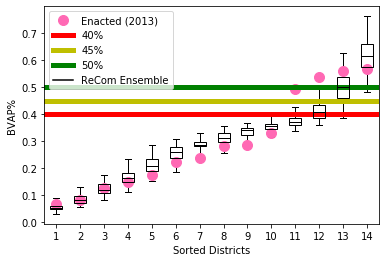

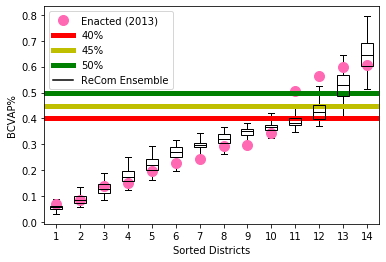

In [54]:
# PLOT SORTED DISTRICTS OVER BVAP %

c='k'

#37 to 55 is opportunity district BVAP range in VA

plt.figure()
plt.boxplot(
            np.array(BVAPS[0]),
            whis=[1, 99],
            showfliers=False,
            patch_artist=True,
            boxprops=dict(facecolor="None", color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
)
sorted_d_nums = [1,2,3,4,5,6,7, 8, 9, 10, 11, 12, 13, 14]
sorted_BPOP = sorted([.295, .51, .233, .571, .58, .125, .179, .298, .069, .247, .149, .343, .55, .086])
plt.plot(sorted_d_nums, enacted_CD113_BVAP, 'o', color="hotpink", label="Enacted (2013)",markersize=10)

plt.axhline(y=.4,color='r',label="40%",linewidth=5)

plt.axhline(y=.45,color='y',label="45%",linewidth=5)

plt.axhline(y=.5,color='g',label="50%",linewidth=5)
plt.plot([],[],color='k',label="ReCom Ensemble")
plt.xlabel("Sorted Districts")
plt.ylabel("BVAP%")

plt.legend()

plt.show()


# PLOT SORTED DISTRICTS OVER CBVAP %

plt.figure()
plt.boxplot(
            np.array(BCVAPS[0]),
            whis=[1, 99],
            showfliers=False,
            patch_artist=True,
            boxprops=dict(facecolor="None", color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
)

plt.plot(sorted_d_nums, enacted_CD113_BCVAP, 'o', color="hotpink", label="Enacted (2013)",markersize=10)

plt.axhline(y=.4,color='r',label="40%",linewidth=5)

plt.axhline(y=.45,color='y',label="45%",linewidth=5)

plt.axhline(y=.5,color='g',label="50%",linewidth=5)
plt.plot([],[],color='k',label="ReCom Ensemble")
plt.xlabel("Sorted Districts")
plt.ylabel("BCVAP%")

plt.legend()

plt.show()

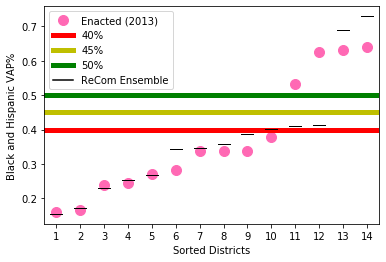

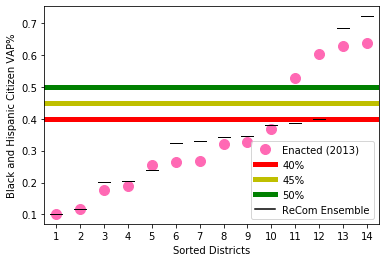

In [101]:
# PLOT SORTED DISTRICTS OVER BVAP %

c='k'

#37 to 55 is opportunity district BVAP range in VA

plt.figure()
plt.boxplot(
            np.array(BHVAPS[0]),
            whis=[1, 99],
            showfliers=False,
            patch_artist=True,
            boxprops=dict(facecolor="None", color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
)
sorted_d_nums = [1,2,3,4,5,6,7, 8, 9, 10, 11, 12, 13, 14]
sorted_BPOP = sorted([.295, .51, .233, .571, .58, .125, .179, .298, .069, .247, .149, .343, .55, .086])
plt.plot(sorted_d_nums, enacted_CD113_BHVAP, 'o', color="hotpink", label="Enacted (2013)",markersize=10)

plt.axhline(y=.4,color='r',label="40%",linewidth=5)

plt.axhline(y=.45,color='y',label="45%",linewidth=5)

plt.axhline(y=.5,color='g',label="50%",linewidth=5)
plt.plot([],[],color='k',label="ReCom Ensemble")
plt.xlabel("Sorted Districts")
plt.ylabel("Black and Hispanic VAP%")

plt.legend()

plt.show()


# PLOT SORTED DISTRICTS OVER CBVAP %

plt.figure()
plt.boxplot(
            np.array(BHCVAPS[0]),
            whis=[1, 99],
            showfliers=False,
            patch_artist=True,
            boxprops=dict(facecolor="None", color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
)

plt.plot(sorted_d_nums, enacted_CD113_BHCVAP, 'o', color="hotpink", label="Enacted (2013)",markersize=10)

plt.axhline(y=.4,color='r',label="40%",linewidth=5)

plt.axhline(y=.45,color='y',label="45%",linewidth=5)

plt.axhline(y=.5,color='g',label="50%",linewidth=5)
plt.plot([],[],color='k',label="ReCom Ensemble")
plt.xlabel("Sorted Districts")
plt.ylabel("Black and Hispanic Citizen VAP%")

plt.legend()

plt.show()

In [118]:
def draw_plot(data, offset, edge_color, fill_color):
    pos = 5*np.arange(data.shape[1])+1+offset
    #bp = ax.boxplot(data, positions= pos, widths=0.3, patch_artist=True, manage_xticks=False)
    bp = ax.boxplot(data, positions= pos,widths=1, whis=[1,99],showfliers=False, patch_artist=True, manage_xticks=False,zorder=4)
    for element in ['boxes', 'whiskers', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color,zorder=4)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color,zorder=0)



/Users/esim/miniconda3/envs/VRDI/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: The 'manage_xticks' parameter of boxplot() has been renamed 'manage_ticks' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  after removing the cwd from sys.path.
/Users/esim/miniconda3/envs/VRDI/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: The 'manage_xticks' parameter of boxplot() has been renamed 'manage_ticks' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  after removing the cwd from sys.path.
/Users/esim/miniconda3/envs/VRDI/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: The 'manage_xticks' parameter of boxplot() has been renamed 'manage_ticks' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  after removing the cwd from sys.path.
/Users/esim/miniconda3/envs/VRDI/lib/python3.7/site-packages/ipykernel_launcher.py:4: Matplotl

<Figure size 432x288 with 0 Axes>

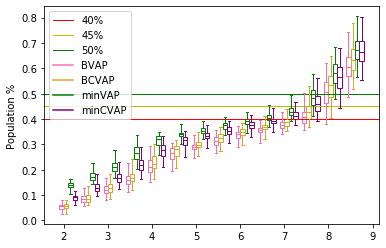

In [119]:
colors = ['hotpink','goldenrod','green','purple']
labels= ['BVAP','BCVAP','minVAP','minCVAP']

plt.figure()

fig, ax = plt.subplots()
draw_plot(np.array(BVAPS[0]),-1.5,colors[0],'w')
draw_plot(np.array(BCVAPS[0]),-.5,colors[1],'w')
draw_plot(np.array(BHVAPS[0]),.5,colors[2],'w')
draw_plot(np.array(BHCVAPS[0]),1.5,colors[3],'w')
ax.set_xticklabels(sorted_d_nums)
plt.axhline(y=.4,color='r',label="40%",linewidth=1)

plt.axhline(y=.45,color='y',label="45%",linewidth=1)

plt.axhline(y=.5,color='g',label="50%",linewidth=1)
plt.ylabel("Population %")

for i in range(4):
    plt.plot([],[],color=colors[i],label=labels[i])
    
#plt.plot(sorted_d_nums, enacted_CD113_BVAP, 'o', color="hotpink", label="Enacted (2013)",markersize=10)

plt.legend()
plt.show()

# Summary:

After running a neutral chain for 10,000 steps at the tract level, we kept track of 4 variables in every step of the chain: BVAP, BCVAP, minority (Black and Hispanic) VAP, and minority CVAP. We were interested in the following questions:

1: By changing the population basis of redistricting from voting age population to citizen voting age population, what effects can we observe?
2: The Hispanic population is the fastest growing racial group in Georgia. If we assume that Hispanic and Black voters vote in a bloc, will we be able to create more minority opportunity districts? 
3: What are the maximum number of majority-minority districts that can be drawn under the 4 different bases? What is the average number? 

Currently, Georgia has 4 majority minority districts. Each one currently is seated by a Black representative. 

## BVAP vs. BCVAP

There are no more MM districts that can be drawn when the redistricting is done in respect to BVAP. 

## minVAP vs. minCVAP

Interesting observation:

Obviously if you include more minority populations in creating your plots, you would expect more districts to be bumped into majority minority district opportunity range. However, what you notice is that the locations of Hispanic voters and Black voters fairly do not overlap. The currently existing majority minority districts do not get more bumped in average compared to the BVAP/BCVAP plots, which suggests that those districts have a high clustering of Black voters. The mid-range districts that were previously close to the opportunity range are bumped a little cloer, but not significantly to render conclusions. However, you can see how much the other districts that have a low black voter % have a significant difference in the population % jumping. Also interesting that the difference between BHVAP and BCHVAP is super different -- noddinf to the citizenship status of the hispanc populations in those areas of georgia. 


Next steps:
Count the max # of majority-minority districts  that can be drawn 
Count the average


In [ ]:
def accept_packed_BVAP(part):
    if part.parent is not None:
        BVAPs = part["BVAP"].percents("BVAP")
        MM_districts = list(filter(lambda x: (x > .5), BVAPs))
        print(MM_districts)
        if (len(MM_districts) < 4): 
            print("HERE")
            return False
        else:
            return True
        
        
    #how many districts have a (50%-55%)
    #is there < 4 
    #for each step in the chain, record the number of majority minority districts 
    #100 steps initially 